XGBoost, Linear Regression, Ridge, Lasso, SVR, Linear SVR, RF, AdaBoost, NN, KNeighborsRegressor

# Import

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import random
from IPython.display import clear_output

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('drive/My Drive/DS301')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('recs2015_public_v4.csv')
# df.set_index('DOEID', inplace=True)

# Clean

In [4]:
df.dropna(inplace=True)

In [5]:
df

,DOEID,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,...,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
0,10001,4,10,METRO,U,2,0,0,0,-2,...,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
2,10003,3,6,METRO,U,2,0,1,0,1,...,0,100.14,1,0,137.45,-2,-2,91.33,-2,-2
4,10005,1,2,METRO,U,2,0,1,0,0,...,0,102.83,1,0,137.45,-2,-2,91.33,-2,-2
6,10007,3,5,METRO,U,4,0,-2,-2,-2,...,0,102.79,1,0,137.45,-2,-2,91.33,-2,-2
7,10008,2,3,METRO,R,2,0,1,0,1,...,0,101.53,1,0,137.45,-2,-2,91.33,-2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5673,15674,1,2,METRO,U,2,0,1,0,1,...,0,98.69,1,0,137.45,-2,-2,91.33,-2,-2
5674,15675,4,8,MICRO,C,2,0,1,0,1,...,0,89.69,1,0,137.45,-2,-2,91.33,-2,-2
5678,15679,2,3,METRO,U,2,0,0,0,-2,...,0,100.23,1,0,137.45,-2,-2,91.33,-2,-2
5681,15682,2,3,METRO,U,5,0,-2,-2,-2,...,1,102.40,5,1,137.45,-2,-2,91.33,-2,-2


In [6]:
indicators = [column for column in df.columns if column.startswith('Z')]
len(indicators)

217

In [7]:
df.drop(columns=indicators, inplace=True)
df = pd.get_dummies(data=df)

# Select Features

In [8]:
# X = df.drop(columns=[column for column in df.columns if column.startswith('TOTAL')], inplace=False)
X = df.loc[:, :'DBT99']
X = X.drop(columns=[column for column in X.columns if column.startswith('BRRWT')], inplace=False)

In [9]:
y = df['TOTALBTU']

In [10]:
X.columns

Index(['DOEID', 'REGIONC', 'DIVISION', 'TYPEHUQ', 'CELLAR', 'BASEFIN', 'ATTIC',
       'ATTICFIN', 'STORIES', 'PRKGPLC1',
       ...
       'CDD80', 'HDD30YR', 'HDD65', 'HDD50', 'GNDHDD65', 'WSF', 'OA_LAT',
       'GWT', 'DBT1', 'DBT99'],
      dtype='object', length=279)

# Split data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Custom Function

In [12]:
def evaluate(regressor, metrics, metric_frame, X_train, X_test, y_train, y_test, regressor_name=None, feature_importance=True, regressor_params={}, param_grid={}):
    
    name = regressor_name if regressor_name else regressor.__name__
    
    # Use GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(regressor(**regressor_params), param_grid, n_jobs=-1)
    grid.fit(X_train, y_train)
    if grid.best_params_:
        print(grid.best_params_)
    
    # Train the model on all features
    reg = regressor(**regressor_params, **grid.best_params_)
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    
    # Calculate RMSE
    rmse_train = math.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
    rmse_test = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))
    
    # Create subplots to show scatterplot for both training and testing
    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
    
    # Scatterplot for training
    axs[0].scatter(x=y_pred_train, y=y_train, s=1)
    axs[0].set_xlabel('Predict')
    axs[0].set_ylabel('Actual')
    axs[0].set_title(f'{name} - Train - RMSE: {rmse_train}')
    
    # Scatterplot for testing
    axs[1].scatter(x=y_pred_test, y=y_test, s=1)
    axs[1].set_xlabel('Predict')
    axs[1].set_ylabel('Actual')
    axs[1].set_title(f'{name} - Test - RMSE: {rmse_test}')
    
    # Save the plots
    plt.savefig(f'{name}.png')
    plt.show()
        
    # Calculate baseline metrics
    for metric in metrics:
        metric_frame.at[name, metric.__name__] = metric(y_true=y_test, y_pred=y_pred_test)

    if feature_importance:
        # Use permutation_importance to evaluate feature importance 
        permutation_metrics = {metric.__name__:make_scorer(metric) for metric in metrics}
        r_multi = permutation_importance(reg, X_test, y_test, n_repeats=30, random_state=0, scoring=permutation_metrics)
        for metric in r_multi:
            print(f"{metric}")
            r = r_multi[metric]
            # Limit to printing 5 most important features
            for i in r.importances_mean.argsort()[::-1][:5]:
                # if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
                    print(f"    {X_test.columns[i]:<25}"
                          f"{r.importances_mean[i]:.3f}"
                          f" +/- {r.importances_std[i]:.3f}")

# Metrics

In [13]:
# metrics must accept parameters y_true and y_pred
metrics = [mean_squared_error, mean_absolute_error, r2_score]
# make a DataFrame to store the baseline metrics
metric_frame = pd.DataFrame(dtype='float64')

# Linear Regression

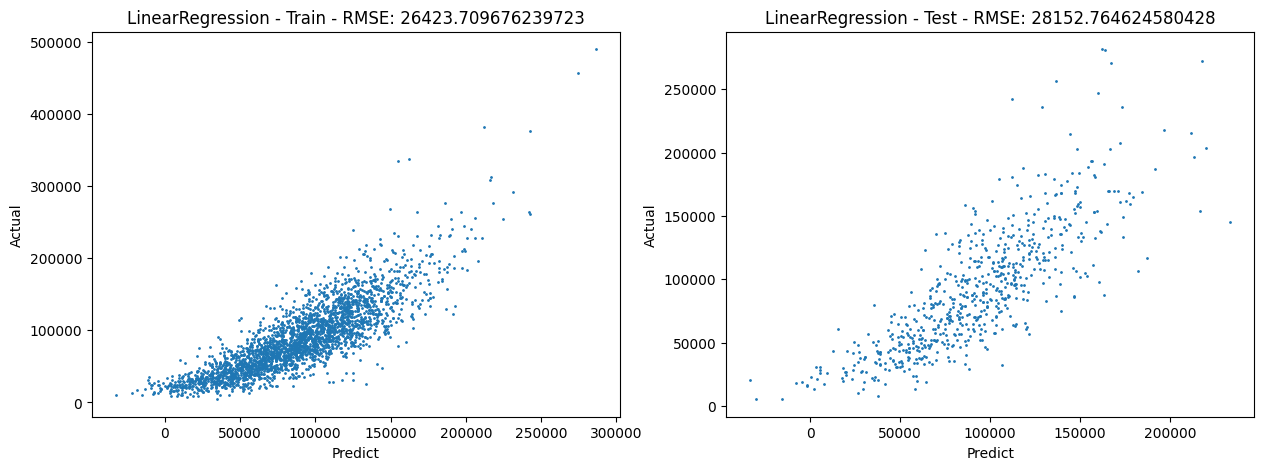

mean_squared_error
    SEPCOOKTUSE              4386620.199 +/- 3595692.425
    TVCOLOR                  4235837.002 +/- 3199849.305
    ELFOOD                   4086990.602 +/- 4674918.656
    TOASTOVN                 4079763.499 +/- 2906915.847
    MICRO                    3282122.659 +/- 1782958.976
mean_absolute_error
    ELFOOD                   191.481 +/- 82.150
    SEPCOOKTUSE              116.059 +/- 57.065
    HOTMA                    68.920 +/- 40.970
    AGECWASH                 60.140 +/- 76.952
    BASECOOL                 52.453 +/- 46.586
r2_score
    NHSLDMEM                 4.239 +/- 0.152
    NUMCHILD                 2.182 +/- 0.095
    NUMADULT                 1.864 +/- 0.091
    PRKGPLC1                 1.226 +/- 0.059
    HDD65                    1.072 +/- 0.044


In [14]:
evaluate(LinearRegression, metrics, metric_frame, X_train, X_test, y_train, y_test, None, True, 
         {})

# XGBoost

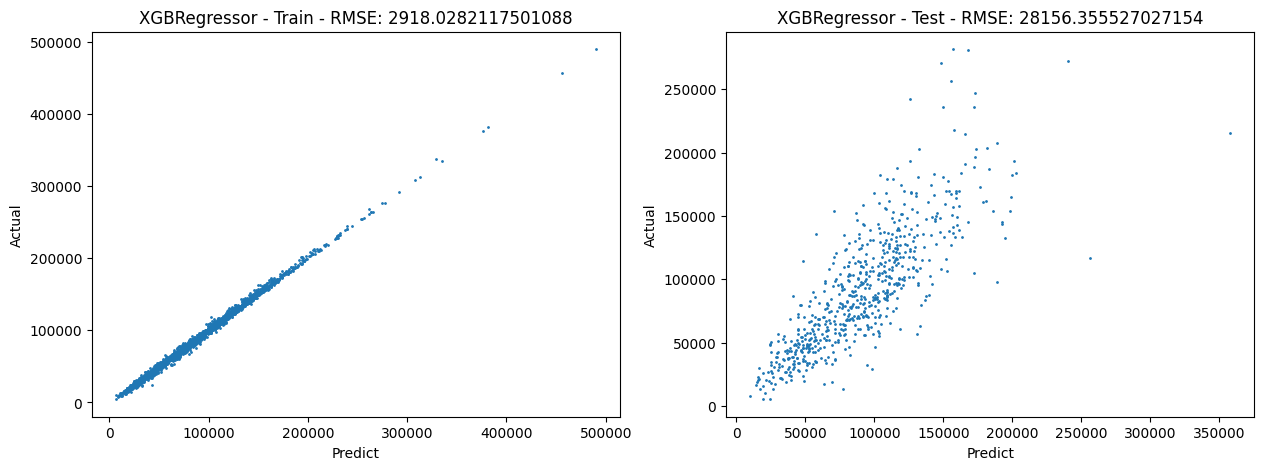

mean_squared_error
    MONPOOL                  39707975.729 +/- 12577797.368
    DRYRUSE                  15099281.917 +/- 11134589.901
    TOTHSQFT                 15098968.162 +/- 13990801.191
    WASHLOAD                 14532649.358 +/- 5628526.291
    TOTROOMS                 14021314.574 +/- 9897358.110
mean_absolute_error
    MONPOOL                  128.837 +/- 123.343
    TOASTOVN                 103.939 +/- 35.580
    TOTROOMS                 103.904 +/- 119.174
    USENOTMOIST              78.801 +/- 44.896
    WHEATAGE                 78.472 +/- 43.069
r2_score
    TOTSQFT_EN               0.108 +/- 0.014
    WINDOWS                  0.043 +/- 0.008
    HDD50                    0.041 +/- 0.006
    DIVISION                 0.039 +/- 0.011
    TYPEHUQ                  0.038 +/- 0.005


In [15]:
evaluate(XGBRegressor, metrics, metric_frame, X_train, X_test, y_train, y_test, None, True, 
         {'objective':'reg:squarederror', 'random_state':0})

# Linear SVR

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


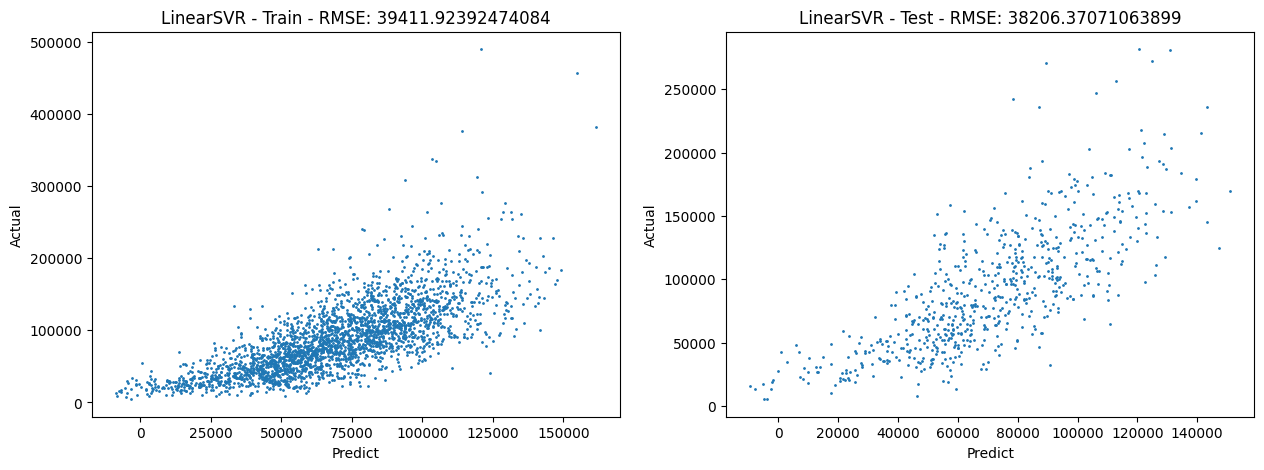

mean_squared_error
    NWEIGHT                  7268196.738 +/- 4429575.966
    AGECWASH                 3151018.538 +/- 1799977.058
    DOEID                    2274501.775 +/- 3244511.163
    AGECDRYER                889334.810 +/- 328476.176
    WWACAGE                  693769.593 +/- 474892.463
mean_absolute_error
    DBT99                    106.044 +/- 30.058
    GNDHDD65                 105.797 +/- 89.532
    AGECWASH                 59.547 +/- 28.521
    GWT                      44.602 +/- 14.919
    DBT1                     25.498 +/- 14.033
r2_score
    HDD65                    1.042 +/- 0.043
    HDD30YR                  0.220 +/- 0.021
    TOTSQFT_EN               0.084 +/- 0.008
    CDD65                    0.066 +/- 0.010
    TOTHSQFT                 0.038 +/- 0.004


In [16]:
evaluate(LinearSVR, metrics, metric_frame, X_train, X_test, y_train, y_test, None, True, 
         {'dual':True, 'random_state':0})

# RF

In [17]:
param_grid_rf = {
    'n_estimators':[10, 100],
    'max_depth':[1, 10, 100, None]
}

{'max_depth': 100, 'n_estimators': 100}


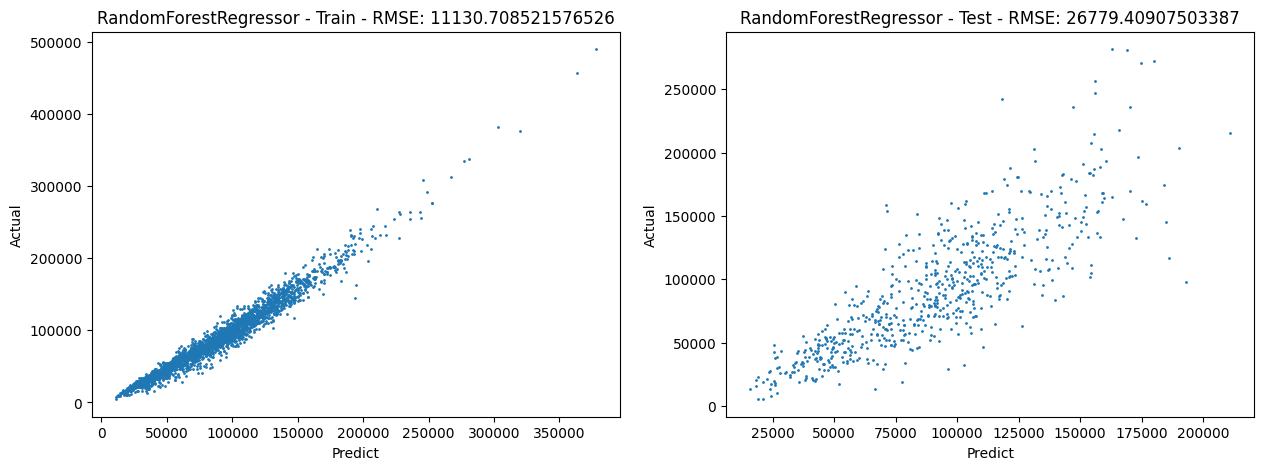

mean_squared_error
    TEMPHOMEAC               1891184.825 +/- 1089885.088
    NUMFRIG                  1742544.393 +/- 1237384.718
    TVSIZE1                  1560729.634 +/- 1050678.594
    CABLESAT                 1296018.094 +/- 1098476.855
    LGTINNUM                 1284596.198 +/- 1714027.142
mean_absolute_error
    SEPCOOKTUSE              36.707 +/- 27.521
    DOEID                    26.740 +/- 27.641
    NUMFRIG                  24.808 +/- 21.452
    CDD65                    16.995 +/- 23.047
    CABLESAT                 16.165 +/- 21.411
r2_score
    TOTSQFT_EN               0.195 +/- 0.018
    WINDOWS                  0.079 +/- 0.010
    HDD50                    0.050 +/- 0.006
    DIVISION                 0.048 +/- 0.010
    DBT99                    0.031 +/- 0.004


In [18]:
evaluate(RandomForestRegressor, metrics, metric_frame, X_train, X_test, y_train, y_test, None, True, 
         {'criterion':'squared_error', 'n_jobs':-1}, param_grid_rf)

# AdaBoost

In [19]:
param_grid_adb = {
    'estimator':[
        DecisionTreeRegressor(max_depth=1),
        DecisionTreeRegressor(max_depth=10),
        DecisionTreeRegressor(max_depth=None)
    ],
    'n_estimators':[10, 50, 100],
    'learning_rate':[0.01, 0.1, 1.0]
}

{'estimator': DecisionTreeRegressor(max_depth=10), 'learning_rate': 1.0, 'n_estimators': 100}


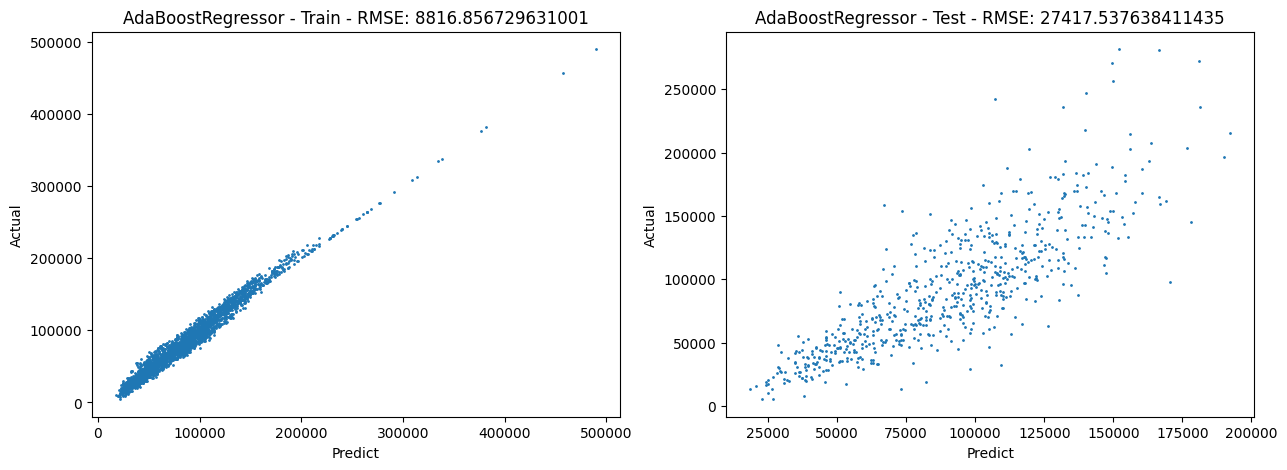

mean_squared_error
    DOEID                    6377696.988 +/- 2013852.499
    WASHTEMP                 2185621.240 +/- 1344316.100
    TVSIZE1                  1935715.958 +/- 866805.352
    AMTMICRO                 1878509.253 +/- 1738675.540
    TVCOLOR                  1833065.633 +/- 2661052.014
mean_absolute_error
    DOEID                    66.634 +/- 43.503
    NUMTABLET                45.234 +/- 20.495
    LGTINLED                 40.516 +/- 19.128
    AMTMICRO                 33.977 +/- 31.789
    DWCYCLE                  31.111 +/- 22.886
r2_score
    TOTSQFT_EN               0.110 +/- 0.011
    WINDOWS                  0.062 +/- 0.007
    HDD50                    0.044 +/- 0.006
    DBT99                    0.020 +/- 0.004
    TYPEHUQ                  0.014 +/- 0.002


In [20]:
evaluate(AdaBoostRegressor, metrics, metric_frame, X_train, X_test, y_train, y_test, None, True, 
         {}, param_grid_adb)

# SVR

In [ ]:
evaluate(BaggingRegressor, metrics, metric_frame, X_train, X_test, y_train, y_test, 'SVR', False, 
         {'estimator':SVR(), 'n_estimators':100, 'bootstrap':True, 'max_samples':0.01, 'n_jobs':-1, 'verbose':True})

# K Neighbors

In [ ]:
evaluate(BaggingRegressor, metrics, metric_frame, X_train, X_test, y_train, y_test, 'KNeighbors', False, 
         {'estimator':KNeighborsRegressor(), 'n_estimators':10, 'bootstrap':True, 'max_samples':0.1, 'n_jobs':1, 'verbose':True})

# Neural Network

## NN - Define Networks

In [23]:
class MLPClassifier_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D, H)
        self.fc2 = nn.Linear(H, C)
    
    def forward(self, x):
        x = activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
class MLPClassifier_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, C)
    
    def forward(self, x):
        x = activation(self.fc1(x))
        x = activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
class MLPClassifier_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, C)
    
    def forward(self, x):
        x = activation(self.fc1(x))
        x = activation(self.fc2(x))
        x = activation(self.fc3(x))
        x = self.fc4(x)
        return x

## NN - Regression Preparation

In [26]:
# Get our device in a variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cpu


In [27]:
X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
y_train_tensor = torch.from_numpy(y_train.values).float().to(device)
X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
y_test_tensor = torch.from_numpy(y_test.values).float().to(device)

In [28]:
def train_reg(model, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.MSELoss()
    model.to(device)
    criterion.to(device)
    for epoch in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            # Get the inputs and labels for the current batch
            X_train, y_train = data
            
            # Move inputs and labels to the device
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass over the model to get the logits 
            y_pred = model(X_train)

            # Compute loss
            loss = criterion(y_pred[:, 0], y_train)

            # reset (zero) the gradients before running the backward pass over the model
            # we need to do this because the gradients get accumulated at the same place across iterations
            optimizer.zero_grad()

            # Backward pass to compute the gradient of loss w.r.t our learnable params (weights and biases)
            loss.backward()

            # Update params
            optimizer.step()
            
            # Update running loss
            running_loss += loss.item()
            
            # Print loss every 1000 mini-batches
            if i % 1000 == 999:
                clear_output(wait=True)
                print(model)
                print(activation)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
            
        # Print progress
        # clear_output(wait=True)
        # print(f'Epoch: {epoch}')

In [29]:
def evaluate_rmse(model, X_test, y_test):
    criterion = nn.MSELoss()
    with torch.no_grad():
        y_pred = model(X_test)
        # print(y_pred)
        mse = criterion(y_pred[:, 0], y_test)
        return math.sqrt(mse)

## NN - Hyperparameter Settings

In [30]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

In [31]:
# First lets setup the hyperparameters for our network architecture
seed = 0
random.seed(seed)
torch.manual_seed(seed)
D = X_train.columns.size  # dimensions
C = 1  # num_classes
H = 100  # num_hidden_units

In [32]:
activations = [nn.Sigmoid(), nn.ReLU(), nn.Tanh(), nn.ELU(), nn.Identity()]
a_names = ['Sigmoid', 'ReLU', 'Tanh', 'ELU', 'None']
models = [MLPClassifier_1, MLPClassifier_2, MLPClassifier_3]
m_names = ['1 layer', '2 layers', '3 layers']
rmses = pd.DataFrame(data=0, dtype='float64', index=m_names, columns=a_names)
epoch = 10
learning_rates = [1e-3, 1e-5, 1e-3, 1e-5, 1e-5]
lambda_l2 = 1e-2 # coefficient for the L2 regularizer. You should play with its value to see the effect of regularization
passes = 1

## NN - Run and Results

In [33]:
for i in range(passes):
    for m, m_name in zip(models, m_names):
        for a, a_name, learning_rate in zip(activations, a_names, learning_rates):
            activation = a
            model = m()
            lr = learning_rate
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=lambda_l2) # built-in L2
            train_reg(model, train_loader, optimizer, epoch)
            rmses.at[m_name, a_name] += evaluate_rmse(model, X_test_tensor, y_test_tensor)
            print(f'Done {m_name}, {a_name}')
rmses = rmses.div(passes)

MLPClassifier_3(
  (fc1): Linear(in_features=279, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=1, bias=True)
)
Identity()
[10,  2000] loss: nan
Done 3 layers, None


In [ ]:
rmses

# Metrics for conventional models

In [ ]:
metric_frame.sort_values(by='mean_squared_error')